In [1]:
from splender.image2 import SplenderImage
import jax.random as random
from jax import vmap, value_and_grad, grad, jit
from interpax import Interpolator1D
from functools import partial

import numpy as np
import jax
import jax.numpy as jnp
from minimum_spanning_tree_inverse_spline_render import get_splines_from_frame

import matplotlib.pyplot as plt

import jax.tree_util as jtu

import optax


In [2]:
dat = np.loadtxt('mnist_train.csv', delimiter=',')

In [3]:
def fit_spline(knots):
    x, y = knots[..., 0], knots[..., 1]
    
    s = jnp.linspace(0, 1, len(x))
    x_spline = Interpolator1D(s, x, method="cubic2")
    y_spline = Interpolator1D(s, y, method="cubic2")
    return x_spline, y_spline

def get_uniform_points(x_spline, y_spline, n_points_per_spline = 8):
    eps = 1e-6
    # Compute arc length
    dx_ds = vmap(partial(x_spline, dx=1))
    dy_ds = vmap(partial(y_spline, dx=1))
    s_fine = jnp.linspace(0, 1, n_points_per_spline)
    ds_vals = jnp.sqrt(dx_ds(s_fine)**2 + dy_ds(s_fine)**2 + eps)
    delta_s = s_fine[1] - s_fine[0]
    cumulative_length = jnp.concatenate([
        jnp.array([0.0]),
        jnp.cumsum(0.5 * (ds_vals[1:] + ds_vals[:-1]) * delta_s)
    ])
    s_uniform = jnp.interp(jnp.linspace(0, cumulative_length[-1], n_points_per_spline), cumulative_length, s_fine)
    return s_uniform, cumulative_length[-1]

def downsample_points(coords):
    x_spline, y_spline = fit_spline(coords)
    s_uniform, length = get_uniform_points(x_spline, y_spline, n_points_per_spline=8)
    x = x_spline(s_uniform)
    y = y_spline(s_uniform)
    return jnp.stack([x, y], axis=-1)

31
(8, 2)


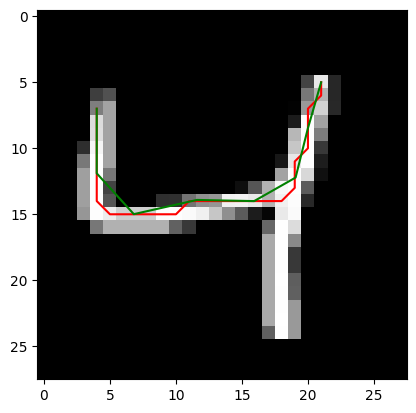

18
(8, 2)


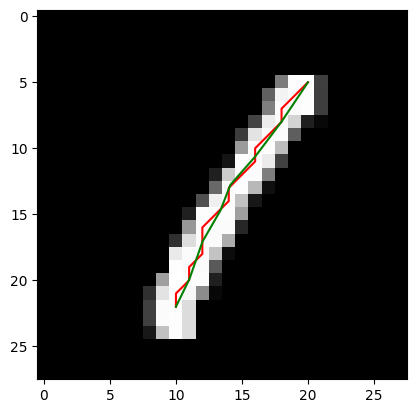

In [4]:
i = 2
images = []
init_splines = []
for i in [2, 3]:
    img = dat[i, 1:].reshape(28, 28)
    img = img / 255.0
    images.append(img)
    path = get_splines_from_frame(img, 0.1)[0][:, ::-1]
    print(len(path))
    init_spline = np.array(path).astype(np.float32)
    init_spline = downsample_points(init_spline)
    init_splines.append(init_spline[None])
    print(init_spline.shape)
    plt.imshow(img, cmap='gray')
    plt.plot(path[:, 0], path[:, 1], 'r-')
    plt.plot(init_spline[:, 0], init_spline[:, 1], 'g-')
    plt.show()

In [5]:
images = jnp.array(images)

In [6]:
init_splines = jnp.array(init_splines) / 28

In [7]:
# model = SplenderImage(random.PRNGKey(0), init_splines, res = 28)
model = SplenderImage()

In [8]:
model = model.init(random.PRNGKey(0), init_knots=init_splines, res=28)

In [9]:
model.res

28

In [10]:
model.loc_params

Array([[[[-0.2523591 , -0.48587483,  5.        ]]],


       [[[ 0.05236834, -0.04692993,  5.        ]]]], dtype=float32)

In [11]:
ims, lengths, curvatures = model()

In [12]:
ims

Array([[[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        ...,
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]],

       [[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        ...,
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]]], dtype=float32)

In [13]:
model.loc_params

Array([[[[-0.2523591 , -0.48587483,  5.        ]]],


       [[[ 0.05236834, -0.04692993,  5.        ]]]], dtype=float32)

In [ ]:
def make_step(model, images, opt_state):
    def loss(model, images):
        recon, lengths, curvatures = model()
        recon_loss = jnp.mean((images - recon) ** 2)
        min_scale_knots = jax.nn.sigmoid((model.loc_params + model.knot_params)[..., 2]).min(axis = -1)
        # jax.debug.print("min_scale_knots: {min_scale_knots}", min_scale_knots=min_scale_knots)
        scale_multiplier_reg = 1e-3 * ((min_scale_knots - 1.0)**2).mean()
        return recon_loss + scale_multiplier_reg
    
    # loss_value, grads = value_and_grad(loss)(model, images)
    grad = jit(grad(loss))
    grads = grad(model, images)
    # jax.debug.print("loss: {loss_value}", loss_value=loss_value)
    # jax.debug.print("grads: {grads}", grads=grads)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = optax.apply_updates(model, updates)
    return model, opt_state

In [15]:
model.loc_params

Array([[[[-0.2523591 , -0.48587483,  5.        ]]],


       [[[ 0.05236834, -0.04692993,  5.        ]]]], dtype=float32)

In [16]:
optim = optax.adam(1e-2)
losses = []
opt_state = optim.init(model)
for step in range(199):
    model, opt_state = make_step(model, images, opt_state)

E0416 14:36:11.202233  196224 pjrt_stream_executor_client.cc:3045] Execution of replica 0 failed: INTERNAL: CUDA error: Failed to load in-memory CUBIN (compiled for a different GPU?).: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered


XlaRuntimeError: INTERNAL: CUDA error: Failed to load in-memory CUBIN (compiled for a different GPU?).: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered

In [ ]:
optim = optax.adam(1e-4)
opt_state = optim.init(model)
for step in range(1):
    model_s, opt_state, loss_value = make_step(model, images, opt_state)
    # model_s, opt_state, loss_value = make_step(model, images, opt_state, filter_splines)
    losses.append(loss_value)

ValueError: not enough values to unpack (expected 3, got 2)

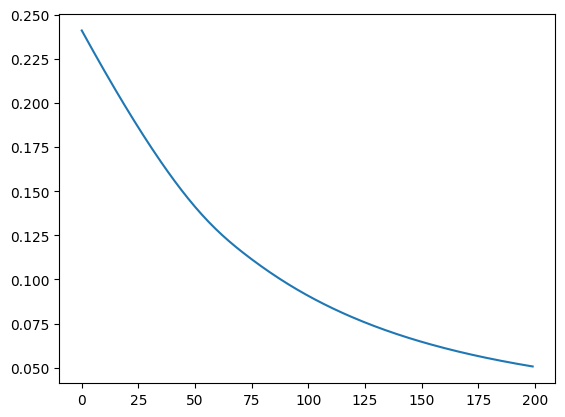

In [ ]:
plt.plot(losses)
# plt.ylim(0.0665, 0.0668)

In [ ]:
ims, lengths, curvatures = model()

In [ ]:
print("model.loc_params", model.loc_params)
print("model.knot_params", model.knot_params)
print("model.global_scale", model.global_scale)
print("model.brush_profile", model.brush_profile)
print("model.kernel", model.kernel)
print("model.opacity", model.opacity)

model.loc_params [[[[-0.2523591  -0.48587483  5.        ]]]


 [[[ 0.05236834 -0.04692993  5.        ]]]]
model.knot_params [[[[ 1.3509717  -1.0401814   0.        ]
   [ 1.1681991  -0.34738296  0.        ]
   [ 1.0100061   0.23005375  0.        ]
   [ 0.5287676   0.48620737  0.        ]
   [-0.09535694  0.47344255  0.        ]
   [-0.8828923   0.6275515   0.        ]
   [-1.5402946   0.18304649  0.        ]
   [-1.5394003  -0.61273736  0.        ]]]


 [[[-0.64015496  1.3462132   0.        ]
   [-0.48379973  0.9445306   0.        ]
   [-0.3375813   0.49053094  0.        ]
   [-0.14229457  0.14846867  0.        ]
   [-0.03481055 -0.12882312  0.        ]
   [ 0.23786226 -0.4470984   0.        ]
   [ 0.53685635 -0.8746953   0.        ]
   [ 0.8639225  -1.4791262   0.        ]]]]
model.global_scale [0.28]
model.brush_profile [1.         0.69444454 0.4444444  0.25       0.11111107 0.02777776
 0.         0.0277778  0.11111113 0.25       0.44444454 0.69444454
 1.        ]
model.kernel [[0. 0.

In [ ]:
model_s.knot_params

Array([[[[ 1.3510717e+00, -1.0400814e+00, -9.9550620e-05],
         [ 1.1682991e+00, -3.4728298e-01, -9.9237019e-05],
         [ 1.0101061e+00,  2.3015375e-01,  9.9767843e-05],
         [ 5.2886760e-01,  4.8630735e-01, -9.9758996e-05],
         [-9.5256940e-02,  4.7354254e-01, -9.9892648e-05],
         [-8.8299233e-01,  6.2765151e-01, -9.9791294e-05],
         [-1.5401946e+00,  1.8314649e-01, -9.9664299e-05],
         [-1.5393003e+00, -6.1263740e-01, -9.9723198e-05]]],


       [[[           nan,  1.3463132e+00,  9.9785029e-05],
         [           nan,  9.4443059e-01,  9.9858720e-05],
         [           nan,  4.9063092e-01,  9.9810823e-05],
         [           nan,  1.4856867e-01,  9.9623794e-05],
         [           nan, -1.2872311e-01, -9.9182485e-05],
         [           nan, -4.4699842e-01,  9.9559991e-05],
         [           nan, -8.7479532e-01,  9.9757803e-05],
         [           nan, -1.4792262e+00,  9.9564764e-05]]]],      dtype=float32)

In [ ]:
ims.shape

(2, 28, 28)

In [ ]:
plt.imshow(ims[0], cmap='gray', vmin=0, vmax=1)
plt.show()
plt.imshow(images[0], cmap='gray', vmin=0, vmax=1)
plt.show()
plt.imshow(ims[1], cmap='gray', vmin=0, vmax=1)
plt.show()

: 